In [1]:
import pandas as pd
import numpy as np


from matplotlib import pyplot as plt
import dateutil.relativedelta
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')

In [2]:
df1 = pd.read_csv('affiliates.csv', sep=';')
df2 = pd.read_csv('affiliate_orders.csv', sep=',')

# Приведение дат, к вычисляемому виду
df1.created_at = pd.to_datetime(df1.created_at)
df2.created_at = pd.to_datetime(df2.created_at)

In [3]:
df1.head()

,id,created_at,traffic_amount
0,151,2014-08-22 20:04:38.223152,1434704
1,3792,2020-03-19 11:22:41.411688,653855
2,2513,2018-10-03 16:51:52.393059,381085
3,2704,2019-03-13 16:12:12.506301,360855
4,3340,2019-06-06 16:25:01.741799,180385


In [4]:
# Посмотрим на типы данных в столбцах
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4321 entries, 0 to 4320
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              4321 non-null   int64         
 1   created_at      4321 non-null   datetime64[ns]
 2   traffic_amount  4321 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 101.4 KB


In [5]:
# Посмотрим краткую сводку по каждому столбцу
df1.describe()

,id,created_at,traffic_amount
count,4321.000000,4321,4.321000e+03
mean,2549.974312,2019-01-04 12:01:12.282233600,8.729877e+02
min,1.000000,2013-08-14 05:09:00.142059,0.000000e+00
25%,1126.000000,2017-02-27 13:42:55.094699008,0.000000e+00
50%,2401.000000,2018-08-18 17:11:00.730489088,0.000000e+00
75%,4010.000000,2021-02-16 16:46:50.444285952,0.000000e+00
max,5155.000000,2023-08-01 15:20:21.154377,1.434704e+06
std,1556.216555,NaN,2.562710e+04


* Как можно заметить, всего у нас 4321 партнер
* В среднем с каждого сайта партнера имеем примерно 873 перехода
* Максимальное количество переходов с сайта партнера - 1.43 млн
    * На первый взгляд - аномально большое значение при среднем в 873
* Самый последний добавленный партнер - 1 августа 2023 года, самый первый - 14 августа 2013 года
    * Вероятно, данных о последних добавленных партнерах будет недостаточно, чтобы сделать по ним вывод и из рассмотрения их можно будет исключить

In [6]:
df2.head()

,id,affiliate_id,created_at,state
0,1908655,1,2023-06-09 14:57:51.895548,canceled
1,1982469,1,2023-06-26 15:35:06.922044,held
2,1491902,1,2022-11-05 17:22:29.533635,held
3,1235697,1,2022-07-27 13:54:22.133388,canceled
4,1235831,1,2022-07-27 14:21:33.350998,held


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257914 entries, 0 to 257913
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            257914 non-null  int64         
 1   affiliate_id  257914 non-null  int64         
 2   created_at    257914 non-null  datetime64[ns]
 3   state         257914 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.9+ MB


In [8]:
df2.describe()

,id,affiliate_id,created_at
count,2.579140e+05,257914.000000,257914
mean,1.490389e+06,1040.098824,2022-11-29 19:17:32.199024896
min,9.829150e+05,1.000000,2022-05-01 00:03:46.322417
25%,1.230110e+06,151.000000,2022-07-26 09:28:27.351419648
50%,1.490688e+06,151.000000,2022-11-04 23:53:27.147030528
75%,1.747264e+06,1781.000000,2023-04-19 13:27:36.824879616
max,1.997316e+06,5102.000000,2023-06-29 23:59:51.253851
std,2.966974e+05,1420.739868,NaN


In [9]:
df2.describe(include='object')

,state
count,257914
unique,3
top,held
freq,137615


* Ни в одной из таблиц нет пропущенных значений

<blockquote><h3>A. Проверка эффективности партнеров</h3></blockquote>

Эффективность работы пратнеров логичнее всего будет проверять по средней конверсии (переход на сайт sputnik с сайта партнера) за определенный промежуток времени - столбец в df1 'traffic_amount' с данными за последние полгода

В таблице 2 указаны данные не за последние 6 месяцев, а за период с 2022-05-01 00:03:46.322417 по н.в. Для верного анализа будем рассматривать только данные за последние полгода

In [10]:
six_mo = datetime.now() + dateutil.relativedelta.relativedelta(months=-6)

In [11]:
df22 = df2[df2.created_at > six_mo]
df22.columns = ['customer_id',	'id',	'created_at',	'state'] # переименуем колонки в таблице два для более удобной работы с данными в дальнейшем
df22.head()


,customer_id,id,created_at,state
0,1908655,1,2023-06-09 14:57:51.895548,canceled
1,1982469,1,2023-06-26 15:35:06.922044,held
14,1953298,1,2023-06-19 16:49:19.019532,held
19,1736164,1,2023-04-15 09:06:44.344094,canceled
22,1706079,1,2023-04-02 15:13:39.782732,held


In [12]:
# Сгруппируем данные в таблице 2 по id партнера
df22 = df22.groupby(df22.id, as_index=False).count()

In [13]:
# Отсортируем данные по количеству заказов экскурсий,
# Притом в данном случае нам не важно, проведена экскурсия или нет
df22 = df22.sort_values(by='state', ascending=False)
df22.head()

,id,customer_id,created_at,state
6,151,60818,60818,60818
77,3618,7008,7008,7008
0,1,3527,3527,3527
73,3421,3396,3396,3396
74,3533,3323,3323,3323


In [14]:
print('Среднеее арифметическое количества заказов: ', df22.state.sum()/len(df22.id))
print('Медиана количества заказов: ', df22.state.std())

Среднеее арифметическое количества заказов:  664.7972027972028
Медиана количества заказов:  5132.809807008409


Медиана сильно отличается от среднего арифметического => в данных есть выбросы (скорее из-за тех партнеров, чья конверсия для нашего сайта равна нулю) 

В первом датафрейме нас интересуют те компании, сотрудничество с которыми длится более полугода, поэтому в основном будем рассматривать именно их, но в дальнейшем обязательно уделим отдельное внимание новым компаниям-партнерам (тем, сотрудничество с которыми длится менее полугода)

In [15]:
df11 = df1[df1.created_at < six_mo]
df11

,id,created_at,traffic_amount
0,151,2014-08-22 20:04:38.223152,1434704
1,3792,2020-03-19 11:22:41.411688,653855
2,2513,2018-10-03 16:51:52.393059,381085
3,2704,2019-03-13 16:12:12.506301,360855
4,3340,2019-06-06 16:25:01.741799,180385
...,...,...,...
4316,2935,2019-04-25 12:56:54.878422,0
4317,1821,2018-07-06 23:19:24.203316,0
4318,806,2016-04-17 12:45:29.030112,0
4319,4468,2022-05-01 23:54:09.875088,0


In [16]:
df = df11.merge(df22[['id', 'state']], on = 'id' , how = 'left')
df.columns = ['id', 'created_at', 'traffic_amount', 'count']
df

,id,created_at,traffic_amount,count
0,151,2014-08-22 20:04:38.223152,1434704,60818.0
1,3792,2020-03-19 11:22:41.411688,653855,1645.0
2,2513,2018-10-03 16:51:52.393059,381085,NaN
3,2704,2019-03-13 16:12:12.506301,360855,4.0
4,3340,2019-06-06 16:25:01.741799,180385,1044.0
...,...,...,...,...
4006,2935,2019-04-25 12:56:54.878422,0,NaN
4007,1821,2018-07-06 23:19:24.203316,0,NaN
4008,806,2016-04-17 12:45:29.030112,0,NaN
4009,4468,2022-05-01 23:54:09.875088,0,NaN


In [17]:
f'Всего имеем {len(df11.id)} компаний, сотрудничество с которыи длится более полугода и {len(df1.id) - len(df11.id)} компаний, сотрудничетво с которыми длится менее полугода'

'Всего имеем 4011 компаний, сотрудничество с которыи длится более полугода и 310 компаний, сотрудничетво с которыми длится менее полугода'

Итого в общей таблице мы имеем огромное количество компаний, чья конверсия за последние полгода равна нулю (на целевой сайт - sputnik перешло 0 человек)

Эти компании, вероятно, остались в базе данных, хотя закрылись (или произошло что-то еще). Познакомимся с ними поближе, чтобы принять решение, использовать их в дальнейшем рассмотрении или же нет

In [18]:
df[df.traffic_amount == 0].sort_values(by='count')

,id,created_at,traffic_amount,count
1113,1683,2018-04-24 16:24:32.981649,0,745.0
3995,3618,2019-12-13 11:54:50.332562,0,7008.0
416,2554,2018-11-02 16:01:30.733086,0,NaN
417,1812,2018-07-06 15:14:51.757432,0,NaN
418,3284,2019-05-06 08:55:36.387263,0,NaN
...,...,...,...,...
4006,2935,2019-04-25 12:56:54.878422,0,NaN
4007,1821,2018-07-06 23:19:24.203316,0,NaN
4008,806,2016-04-17 12:45:29.030112,0,NaN
4009,4468,2022-05-01 23:54:09.875088,0,NaN


Отсюда имеем, что только две компании-партнера принесли конверсию (в покупку!) - что очень удивительно. Данных об остальных компаниях нет - их смело можем исключить из дальнейшего рассмотрения на основе имеющихся данных. (принимая предположение о том, что сотрудничество с ними либо находится в паузе, либо компании закрыты)

In [19]:
df

,id,created_at,traffic_amount,count
0,151,2014-08-22 20:04:38.223152,1434704,60818.0
1,3792,2020-03-19 11:22:41.411688,653855,1645.0
2,2513,2018-10-03 16:51:52.393059,381085,NaN
3,2704,2019-03-13 16:12:12.506301,360855,4.0
4,3340,2019-06-06 16:25:01.741799,180385,1044.0
...,...,...,...,...
4006,2935,2019-04-25 12:56:54.878422,0,NaN
4007,1821,2018-07-06 23:19:24.203316,0,NaN
4008,806,2016-04-17 12:45:29.030112,0,NaN
4009,4468,2022-05-01 23:54:09.875088,0,NaN


In [20]:
df = df[(df['count'].isna() == False) | (df.traffic_amount != 0)]
df

,id,created_at,traffic_amount,count
0,151,2014-08-22 20:04:38.223152,1434704,60818.0
1,3792,2020-03-19 11:22:41.411688,653855,1645.0
2,2513,2018-10-03 16:51:52.393059,381085,NaN
3,2704,2019-03-13 16:12:12.506301,360855,4.0
4,3340,2019-06-06 16:25:01.741799,180385,1044.0
...,...,...,...,...
413,2276,2018-07-31 08:11:34.060335,1,NaN
414,4525,2022-06-06 15:02:05.039000,1,NaN
415,3826,2020-05-04 11:50:38.322087,1,NaN
1113,1683,2018-04-24 16:24:32.981649,0,745.0


Из таблицы так же видно, что существуют такие компании-партнеры, чья конверсия в переход на сайт не равна нулю (и составляет внушительные цифры, как в примере с компанией 2513), но при этом конверсия в покупку услуги 'экскурсия' равна нулю. В задании А нас это интересовать не должно (в том числе из-за недостатка данных), но так же стоит задуматься о причинах такого поведения.

Т.о. осталось 417 компаний для дальнейшего анализа.

Для верного ответа на вопрос задания А достаточно отсортировать по убыванию таблицу df по показателю traffic_amount, чтобы выявить топ наиболее эффективных компаний и по убыванию - чтобы показать топ наименее эффективных компаний.

Выведем топ наиболее эффективных компаний-партнеров

In [21]:
df_top30 = df.sort_values(by='traffic_amount', ascending=False).head(30)

In [22]:
positive = df_top30.head(16)
positive

,id,created_at,traffic_amount,count
0,151,2014-08-22 20:04:38.223152,1434704,60818.0
1,3792,2020-03-19 11:22:41.411688,653855,1645.0
2,2513,2018-10-03 16:51:52.393059,381085,NaN
3,2704,2019-03-13 16:12:12.506301,360855,4.0
4,3340,2019-06-06 16:25:01.741799,180385,1044.0
5,3421,2019-08-14 20:33:30.664069,108881,3396.0
6,1,2013-08-14 05:09:00.142059,105208,3527.0
7,555,2015-08-25 17:07:46.171173,92118,2311.0
8,2132,2018-07-19 13:18:06.886362,87665,2473.0
9,1208,2017-06-05 09:09:19.390902,53630,15.0


In [23]:
print(positive.id.to_numpy())

[ 151 3792 2513 2704 3340 3421    1  555 2132 1208 1032 3533 1781 4493
  343 2431]


Покажем теперь топ наименее эффективных компаний за последние полгода

In [24]:
df_top_negative = df.sort_values(by='traffic_amount').head(350)

In [25]:
df_top_negative.describe()

,id,created_at,traffic_amount,count
count,350.000000,350,350.000000,65.000000
mean,2247.340000,2018-06-29 21:58:29.465962240,57.485714,126.153846
min,9.000000,2013-10-11 00:46:06.811300,0.000000,1.000000
25%,753.250000,2016-03-07 06:15:17.575444992,2.000000,1.000000
50%,1764.000000,2018-06-09 02:51:01.187480576,6.500000,3.000000
75%,3902.000000,2020-08-16 10:44:41.455422464,52.000000,10.000000
max,4813.000000,2023-02-12 21:49:26.893267,534.000000,7008.000000
std,1640.006654,NaN,111.867008,871.785116


Компаний с трафиком до 535 огромное количество - 350 из 417 имеющихся. Поэтому сформируем датафрейм компаний, в котором трафик будет очень маленьким (до 180 переходов за последние полгода)

Выбор 180 обусловлен спецификой компании (а именно - бронирование экскурсий) - здесь не такой высокий спрос, как, например на покупку внутриигровых элементов в онлайн-игре (отсюда и приемлемое значение значительно ниже). Так же мы не располагаем данными о количестве посетителей сайта компании-партнера (отчасти поэтому цифра берется "из воздуха"). Итого окончательно цифра взята по 75% квантилю (см. сводку ниже)

In [26]:
df.describe()

,id,created_at,traffic_amount,count
count,418.000000,418,4.180000e+02,124.000000
mean,2280.050239,2018-07-18 11:22:07.983985408,9.009359e+03,764.475806
min,1.000000,2013-08-14 05:09:00.142059,0.000000e+00,1.000000
25%,784.250000,2016-03-25 10:15:08.607617280,2.000000e+00,3.000000
50%,1828.500000,2018-07-04 14:57:13.597364480,1.500000e+01,12.000000
75%,3907.250000,2020-08-28 04:42:24.531482368,1.805000e+02,73.000000
max,4813.000000,2023-02-12 21:49:26.893267,1.434704e+06,60818.000000
std,1624.355925,NaN,8.203792e+04,5508.160198


In [27]:
negative = df_top_negative.sort_values(by=['traffic_amount', 'count'], ascending=True)[df_top_negative.traffic_amount < 181].fillna(0)

In [28]:
negative = negative[negative['count'] < negative.traffic_amount]
negative

,id,created_at,traffic_amount,count
414,4525,2022-06-06 15:02:05.039000,1,0.0
383,1008,2016-10-28 11:49:29.663887,1,0.0
382,2529,2018-10-16 19:04:15.378186,1,0.0
381,1423,2017-09-15 05:51:00.490453,1,0.0
380,4605,2022-08-13 10:02:19.890274,1,0.0
...,...,...,...,...
109,3980,2021-01-08 10:48:58.751671,154,0.0
108,239,2014-10-20 19:23:54.349971,155,0.0
107,4782,2023-01-18 14:29:50.565207,159,13.0
106,1795,2018-06-25 15:21:47.475996,162,12.0


In [29]:
negative.id.to_numpy()[:16]

array([4525, 1008, 2529, 1423, 4605, 4813, 1255,  120, 2623, 2697, 1162,
       4210,  477,  189,  629,  401], dtype=int64)

In [30]:
f'Всего имеем {len(negative.id)} наименее эффективных компаний. Все они представлены в датафрейме negative'

'Всего имеем 307 наименее эффективных компаний. Все они представлены в датафрейме negative'

<blockquote><h3>Выводы к пункту А</h3></blockquote>

* В ходе анализа мы получили топ наиболее эффективных (positive) компаний и топ наименее эффективных (negative) компаний-партнеров.
* Среди наиболее эффективных компаний присутствует компания, конверсия в покупку которой равна нулю. Вероятно, это недобросовестная компания, которая использует ботов для перехода по ссылке на сайт sputnik. (Это лишь предположение, проверить которое не представляется возможным в рамках задания). Вполне вероятно, что аудитория этой компании абсолютно противоположна ЦА компании sputnik (К примеру, пожилые люди, которые вряд ли будут бронировать экскурсии онлайн)
* Среди наименее эффективных по трафику компаний существуют такие, где очень много бронирований экскурсий (порядка 7000 при 0 перехдов на сайт sputnik). Это может свидетельствовать о том, что пристутсвует ошибка в данных.

Так же рассмотрим компании, с которыми сотрудничество было начато менее полугода назад

In [31]:
df111 = df1[df1.created_at > six_mo]
df111['time_of_friendship'] = datetime.now() - df111.created_at
df111['traffic_per_day'] = df111.traffic_amount / (df111.time_of_friendship / timedelta (days=1))
df111.sort_values(by='traffic_per_day', ascending=False)

,id,created_at,traffic_amount,time_of_friendship,traffic_per_day
31,4874,2023-03-23 11:04:35.937904,3841,142 days 20:32:53.697966,26.887182
64,4954,2023-04-25 17:18:48.827912,597,109 days 14:18:40.807958,5.447264
95,5084,2023-06-16 09:09:26.798589,246,57 days 22:28:02.837281,4.246054
102,4871,2023-03-21 21:23:04.829052,201,144 days 10:14:24.806818,1.391710
114,4879,2023-03-26 00:06:52.334357,154,140 days 07:30:37.301513,1.097547
...,...,...,...,...,...
1737,5149,2023-07-29 10:41:33.073928,0,14 days 20:55:56.561942,0.000000
1753,4855,2023-03-12 23:21:34.978112,0,153 days 08:15:54.657758,0.000000
1770,4990,2023-04-27 10:16:06.263788,0,107 days 21:21:23.372082,0.000000
1784,4847,2023-03-08 15:13:55.151901,0,157 days 16:23:34.483969,0.000000


Сравним результаты с таблицей наиболее эффективных компаний

In [32]:
positive['time_of_friendship'] = datetime.now() - positive.created_at
positive['traffic_per_day'] = positive.traffic_amount / (366/2)
positive.sort_values(by='traffic_per_day', ascending=False)

,id,created_at,traffic_amount,count,time_of_friendship,traffic_per_day
0,151,2014-08-22 20:04:38.223152,1434704,60818.0,3277 days 11:32:51.702171,7839.912568
1,3792,2020-03-19 11:22:41.411688,653855,1645.0,1241 days 20:14:48.513635,3572.978142
2,2513,2018-10-03 16:51:52.393059,381085,NaN,1774 days 14:45:37.532264,2082.431694
3,2704,2019-03-13 16:12:12.506301,360855,4.0,1613 days 15:25:17.419022,1971.885246
4,3340,2019-06-06 16:25:01.741799,180385,1044.0,1528 days 15:12:28.183524,985.710383
5,3421,2019-08-14 20:33:30.664069,108881,3396.0,1459 days 11:03:59.261254,594.978142
6,1,2013-08-14 05:09:00.142059,105208,3527.0,3651 days 02:28:29.783264,574.907104
7,555,2015-08-25 17:07:46.171173,92118,2311.0,2909 days 14:29:43.754150,503.377049
8,2132,2018-07-19 13:18:06.886362,87665,2473.0,1850 days 18:19:23.038961,479.043716
9,1208,2017-06-05 09:09:19.390902,53630,15.0,2259 days 22:28:10.534421,293.060109


Видно, что компания 4874 имеет шансы стать одной из наиболее эффективных компаний в будущем при сохранении хотя бы текущих показателей трафика в день.

<blockquote><h3>Б Топ-15 партнеров для поддержания сотрудничества с целью увеличения прибыли</h3></blockquote>

Прибыль компании напрямую зависит от конверсии в покупку. (Этому предшествует переход пользователя с сайта-партнера на сайт sputnik)

In [33]:
df
df.sort_values(by='traffic_amount', ascending=False, inplace=True)
dff = df.head(20)
dff

,id,created_at,traffic_amount,count
0,151,2014-08-22 20:04:38.223152,1434704,60818.0
1,3792,2020-03-19 11:22:41.411688,653855,1645.0
2,2513,2018-10-03 16:51:52.393059,381085,NaN
3,2704,2019-03-13 16:12:12.506301,360855,4.0
4,3340,2019-06-06 16:25:01.741799,180385,1044.0
5,3421,2019-08-14 20:33:30.664069,108881,3396.0
6,1,2013-08-14 05:09:00.142059,105208,3527.0
7,555,2015-08-25 17:07:46.171173,92118,2311.0
8,2132,2018-07-19 13:18:06.886362,87665,2473.0
9,1208,2017-06-05 09:09:19.390902,53630,15.0


In [34]:
df.sort_values(by='count', ascending=False, inplace=True)

In [35]:
ddf = df[df.traffic_amount > 0].head(20)
ddf['conv2'] = ddf['count']/ddf.traffic_amount * 100
ddf.sort_values(by='conv2', ascending=False, inplace=True)


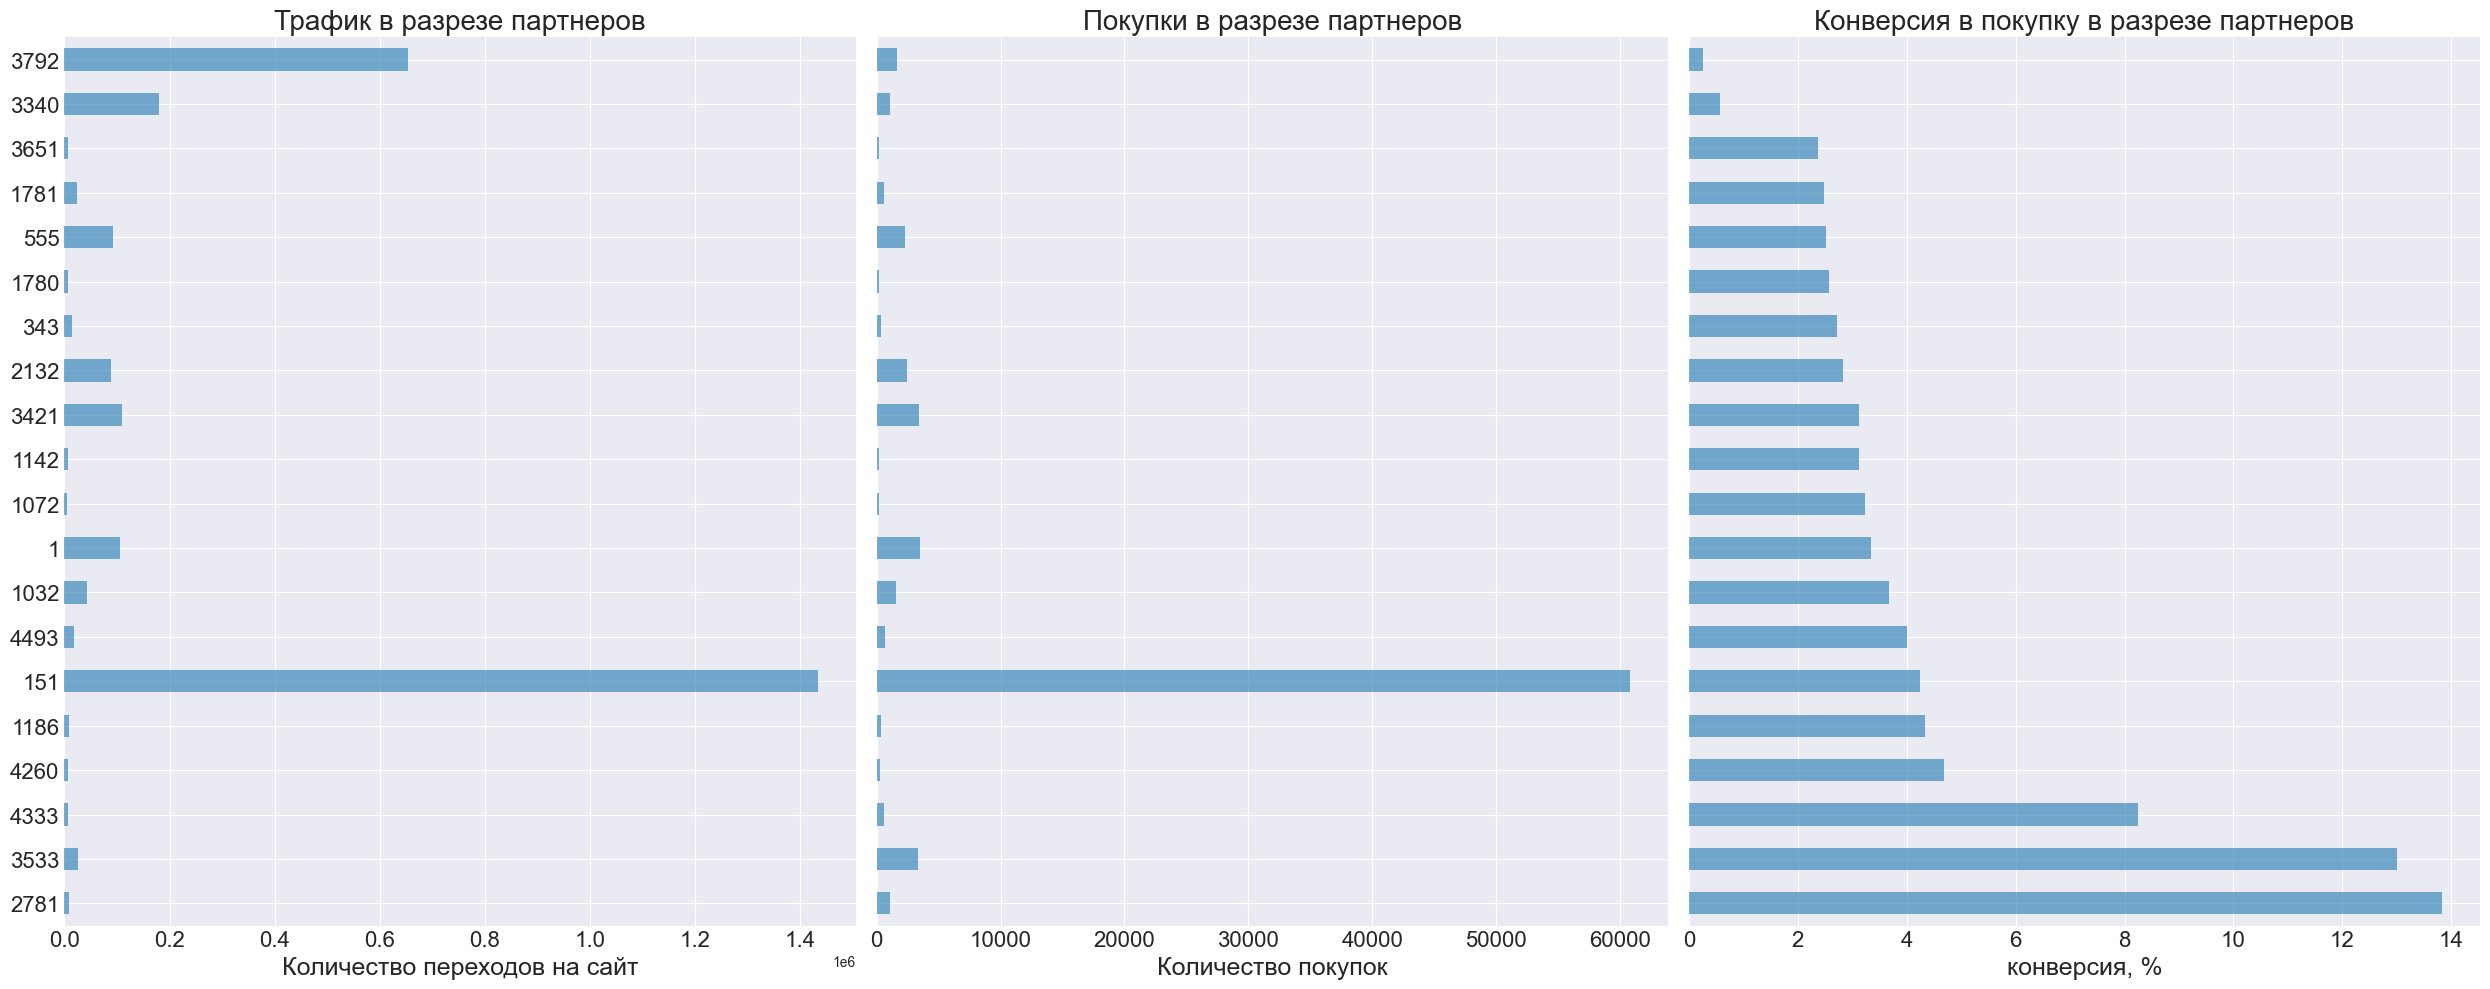

In [36]:
def build_graphs(data):
    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(25, 10))

    data[['traffic_amount', 'id']].plot.barh(y='traffic_amount', x='id', ax=ax[0], legend=None, fontsize=18, alpha=0.6)
    ax[0].set_title('Трафик в разрезе партнеров', fontsize=20)
    ax[0].set_xlabel('Количество переходов на сайт', fontsize=18)
    ax[0].set_ylabel(None)
    ax[0].tick_params(labelsize=16)

    data[['count', 'id']].plot.barh(y='count', x='id', ax=ax[1], legend=None, fontsize=18, alpha=0.6)
    ax[1].set_title('Покупки в разрезе партнеров', fontsize=20)
    ax[1].set_xlabel('Количество покупок', fontsize=18)
    ax[1].set_ylabel(None)
    ax[1].tick_params(labelsize=16)

    data[['conv2', 'id']].plot.barh(y='conv2', x='id', ax=ax[2], legend=None, fontsize=18, alpha=0.6)
    ax[2].set_title('Конверсия в покупку в разрезе партнеров', fontsize=20)
    ax[2].set_xlabel('конверсия, %', fontsize=18)
    ax[2].set_ylabel(None)
    ax[2].tick_params(labelsize=16)

    plt.tight_layout()
    plt.show()

build_graphs(ddf)

Отображение не получается достаточно информативным в первую очередь из-за значительного преобладания трафика от нескольких партнеров в сравнении с другими. Из графика четко видно два таких примера. У одного трафик огромный при конверсии в покупку более 4%, что является успешным результатом. С этой компанией явно нужно продолжать сотрудничество. Притом из-за таких показателей трафика и конверсии предпосылок для улучшения сотрудничества не наблюдается. Их можно исключить из дальнейшего рассмотрения (партнер под id=151). Так же наблюдается компания, конверсия которой менее 1% при большом трафике (можно предположить, что ЦА этой компании (3792) не совпадает с ЦА сайта sputnik). Исключим ее из дальнейшего рассмотрения, поскольку при такой низкой конверсии работать с этой компанией надо индивидуально и выяснять причину столь низкой конверсии (в данном примере мы не располагаем достаточным количеством данных)


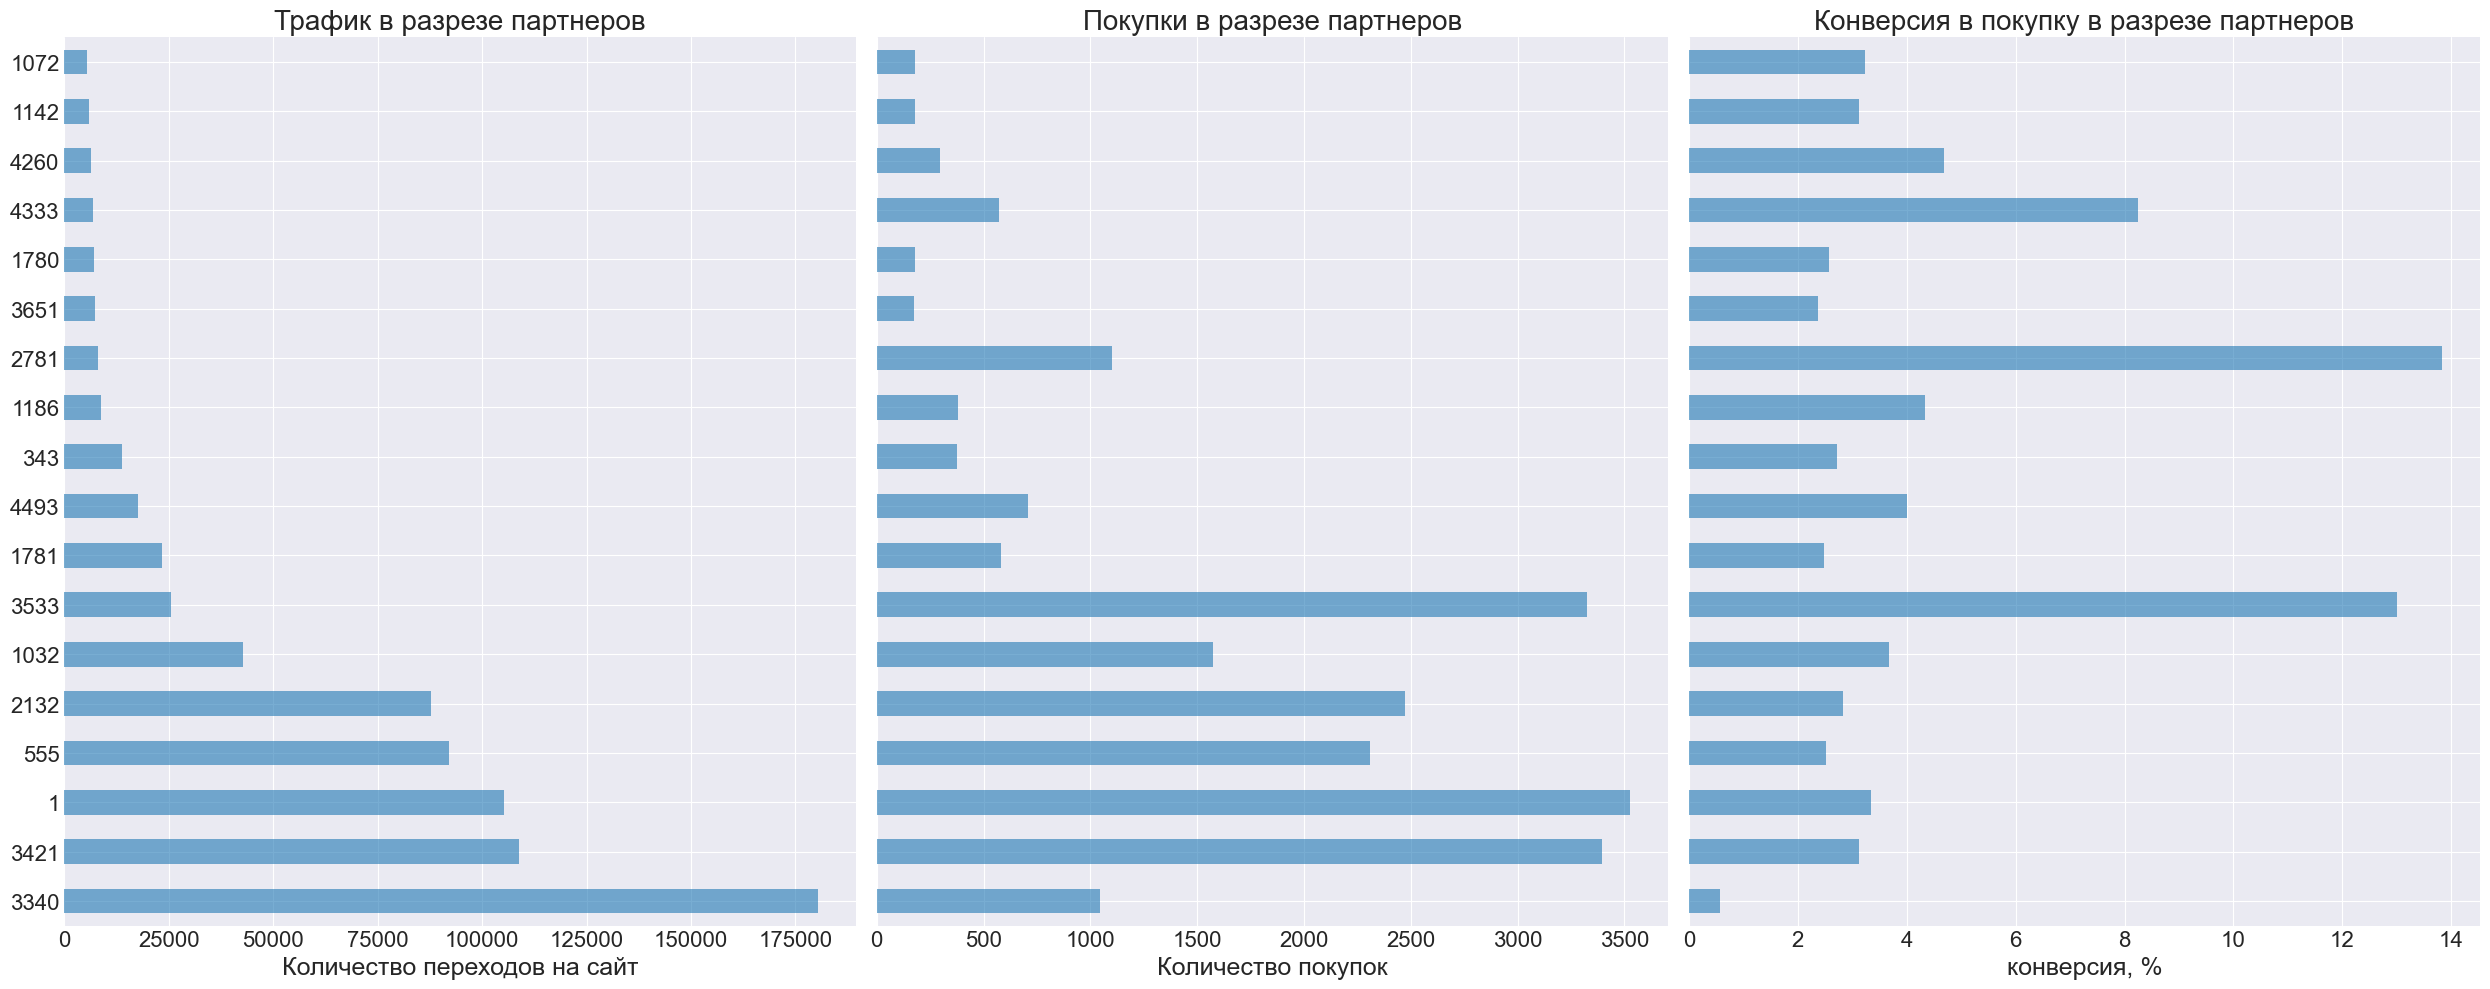

In [37]:
build_graphs(ddf[(ddf.id != 151) & (ddf.id != 3792)].sort_values(by='traffic_amount', ascending=False))

Из графика видно, что необходимо улучшать сотрудничество с первыми 15 компаниями (сверху вниз на графике). На данный момент у них низкий трафик, но неплохая конверсия (> 2-3%), а в некоторых случаях конверсия считается сверх-успешной (более 10%).

In [38]:
friendship_to_improve_df = ddf[(ddf.id != 151) & (ddf.id != 3792)].sort_values(by='conv2', ascending=False)['id']

Список тех, с кем надо улучшать сотрудничество по убыванию значимости (уменьшению конверсии)

In [39]:
friendship_to_improve = friendship_to_improve_df.to_numpy()[:16]
print(friendship_to_improve)

[2781 3533 4333 4260 1186 4493 1032    1 1072 1142 3421 2132  343 1780
  555 1781]


Смущает здесь только наличие компании с id=1 (сотрудничество с которой началось еще в 2013 году), однако нет причин не включать ее в этот список.

<blockquote><h3>Вывод по пункту Б</h3></blockquote>

Топ 15 компаний по убыванию значимости для улучшения сотрудничества в будущем (в качестве основного параметра для сравнения выбрано значение конверсии в покупку на сайте sputnik):

In [40]:
friendship_improve_list = friendship_to_improve.tolist()
print(friendship_improve_list)

[2781, 3533, 4333, 4260, 1186, 4493, 1032, 1, 1072, 1142, 3421, 2132, 343, 1780, 555, 1781]


<blockquote><h3>C Прогноз</h3></blockquote>

Сформируем общий датафрейм с количеством продаж за последние полгода. Отмененные экскурсии не должны здесь учитываться, потому что деньги за эти экскурсии получены не были. Здесь либо можно учитывать процент отмен в прогнозе, либо попросту не включать такие экскурсии в рассмотрение. Выберем второй вариант:)

Выборку будем формировать на основе df2 из задания

Отобразим графически помесячное количество заказов

In [41]:
predict_df = df2[df2.state != 'canceled']

In [42]:
predict_df

,id,affiliate_id,created_at,state
1,1982469,1,2023-06-26 15:35:06.922044,held
2,1491902,1,2022-11-05 17:22:29.533635,held
4,1235831,1,2022-07-27 14:21:33.350998,held
7,1236144,1,2022-07-27 15:33:27.484902,held
9,1236998,1,2022-07-27 19:08:37.540418,held
...,...,...,...,...
257908,1992966,5084,2023-06-28 23:35:26.801357,pending
257909,1969529,5084,2023-06-23 09:13:26.339313,held
257910,1956651,5084,2023-06-20 12:13:04.763848,held
257912,1989282,5098,2023-06-28 09:03:47.265402,held


In [43]:
tr = [i.strftime("%Y-%m") for i in predict_df.created_at]

In [44]:
predict_df.created_at = tr
predict_df

,id,affiliate_id,created_at,state
1,1982469,1,2023-06,held
2,1491902,1,2022-11,held
4,1235831,1,2022-07,held
7,1236144,1,2022-07,held
9,1236998,1,2022-07,held
...,...,...,...,...
257908,1992966,5084,2023-06,pending
257909,1969529,5084,2023-06,held
257910,1956651,5084,2023-06,held
257912,1989282,5098,2023-06,held


In [45]:
predict_df = predict_df.groupby(predict_df.created_at, as_index=False).count()[['created_at', 'id']]
predict_df


,created_at,id
0,2022-05,8446
1,2022-06,13250
2,2022-07,17862
3,2022-08,17822
4,2022-09,8248
5,2022-10,7557
6,2022-11,5977
7,2022-12,5002
8,2023-01,6714
9,2023-02,6628


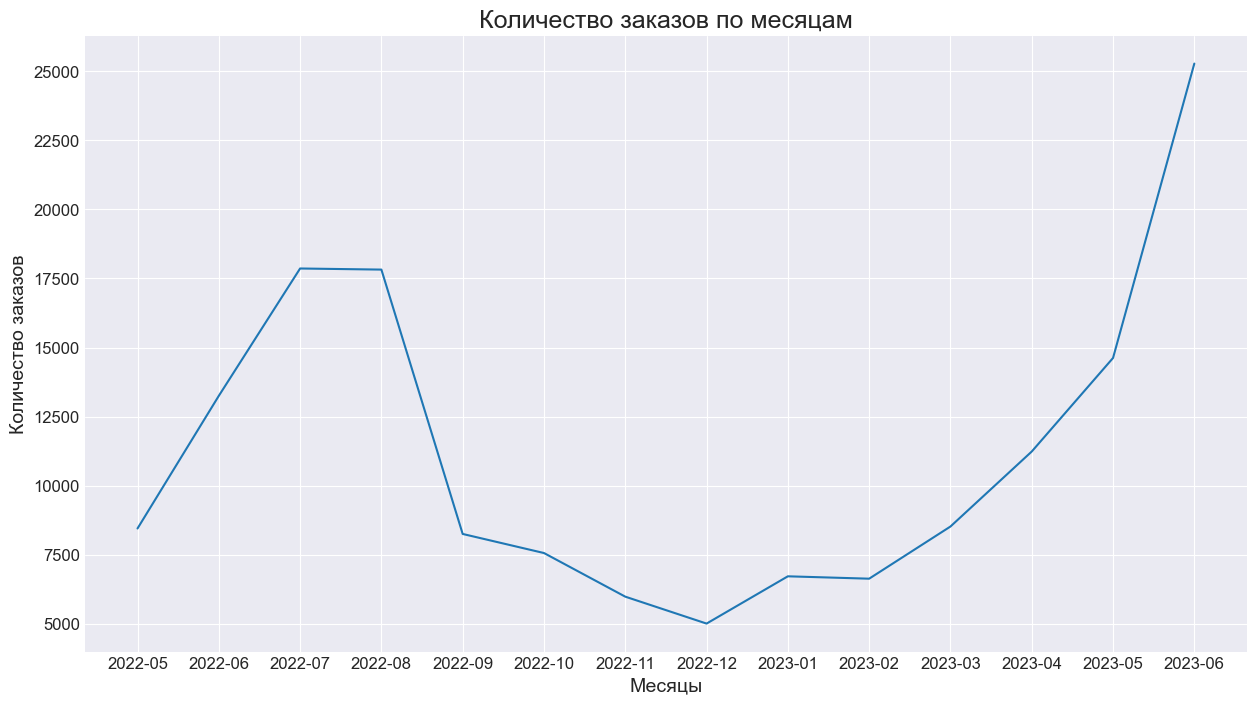

In [46]:
plt.figure(figsize=(15, 8))
plt.plot(predict_df.created_at, predict_df.id)
plt.title('Количество заказов по месяцам', fontsize=18)
plt.tick_params(labelsize=12)
plt.xlabel('Месяцы', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.show()

Понимая, что данные относятся к заказам на экскурсии, можно с некоторой степенью уверенности говорить, о том, что здесь обязательно присутствует сезонность. Если бы данных было больше, об этом можно было бы говорить с большей точностью. Так же непонятен эффект влияния оттока граждан РФ из страны ввиду некоторых обстоятельств. Можно предположить, что эффект был, но, т.к. данные представлены всего за год, его влиянием можно пренебречь в рамках задания.

Временные ряды можно прогнозировать большим количеством способов. Т.к. данных в таблице не очень много (за 1 год и 2 месяца), будем прогнозировать по уравнению линии тренда.

In [47]:
import math

In [48]:
lnY = [math.log(i) for i in predict_df.id]
predict_df["trend"] = predict_df["id"].rolling(window=12).mean()

Выделим линию тредна скользящим средним за 12 месяцев (из предположения, что данные сезонные с периодом 12 месяцев)

In [49]:
predict_df["trend"] = [math.log(i) for i in predict_df["trend"] ]
predict_df

,created_at,id,trend
0,2022-05,8446,NaN
1,2022-06,13250,NaN
2,2022-07,17862,NaN
3,2022-08,17822,NaN
4,2022-09,8248,NaN
5,2022-10,7557,NaN
6,2022-11,5977,NaN
7,2022-12,5002,NaN
8,2023-01,6714,NaN
9,2023-02,6628,NaN


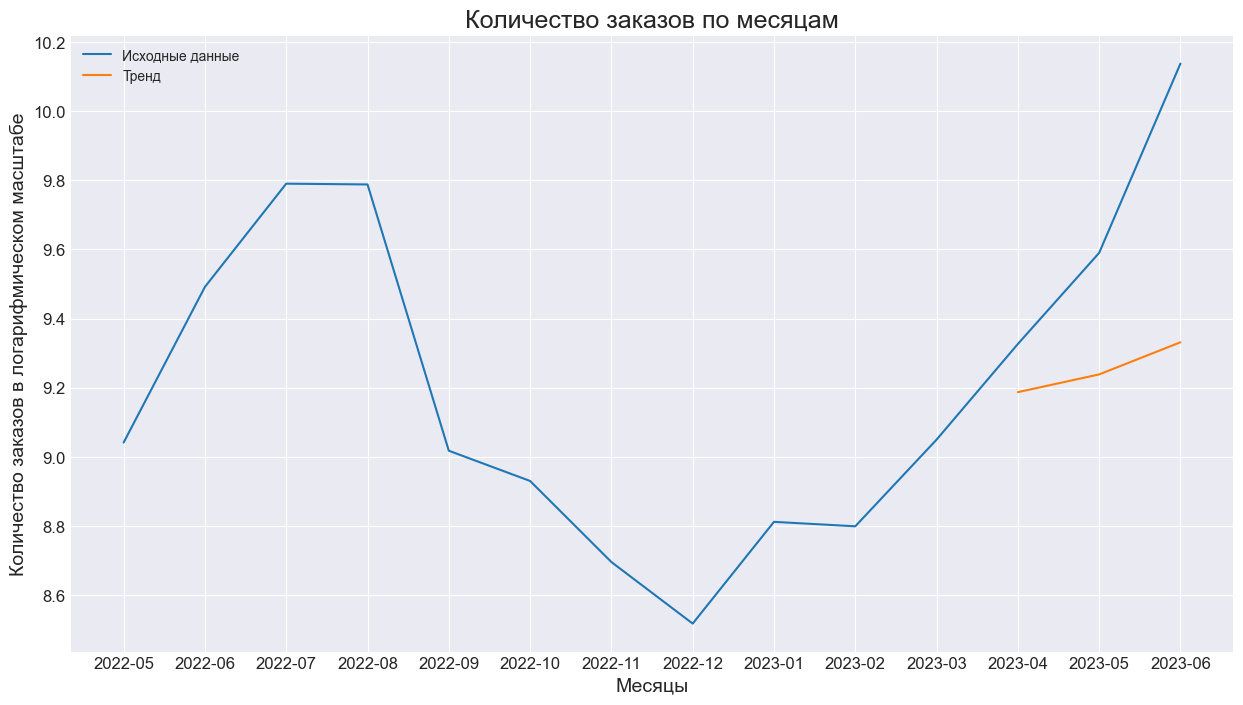

In [50]:
plt.figure(figsize=(15, 8))
plt.plot(predict_df.created_at, lnY, label='Исходные данные' )
plt.plot(predict_df.created_at, predict_df["trend"], label='Тренд')
plt.title('Количество заказов по месяцам', fontsize=18)
plt.tick_params(labelsize=12)
plt.xlabel('Месяцы', fontsize=14)
plt.ylabel('Количество заказов в логарифмическом масштабе', fontsize=14)
plt.legend(loc='upper left')
plt.show()

Далее займемся прогнозом тренда. Для этого аппроксимируем его какой-либо функцией

In [51]:
t = np.polyfit([12, 13, 14], predict_df["trend"][11:], 2)
t

array([ 0.02085046, -0.46993866, 11.8240066 ])

In [52]:
t1 = np.polyfit([12, 13, 14], predict_df["trend"][11:], 1)
t1

array([0.07217317, 8.31417999])

In [53]:
f = np.poly1d(t)
print(f)

         2
0.02085 x - 0.4699 x + 11.82


In [54]:
f1 = np.poly1d(t1)
print(f1)

 
0.07217 x + 8.314


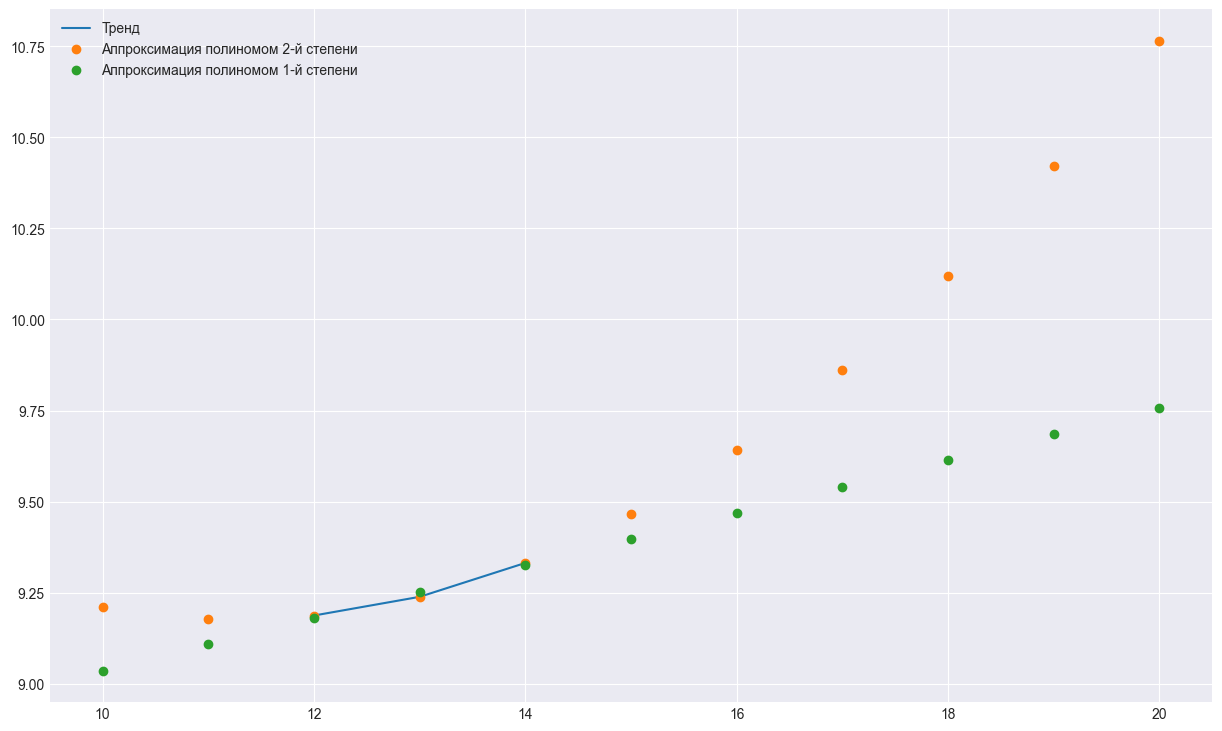

In [55]:
x1 = np.linspace(10, 20, 11)
plt.figure(figsize=(15, 9))
plt.plot([12, 13, 14], predict_df["trend"][11:], label='Тренд')
plt.plot(x1, f(x1), 'o', label='Аппроксимация полиномом 2-й степени')
plt.plot(x1, f1(x1), 'o', label='Аппроксимация полиномом 1-й степени')
plt.legend(loc='upper left')
plt.show()

Аппроксимация полиномом второго порядка ближе к истине даже при простом визуальном осмотре. Выберем аппроксимацию полиномом второго порядка с уравнением y = 0.02085 x^2 - 0.4699 x + 11.82

Вычислим точечно прогнозы на август и сентябрь (соответственно и на июль тоже)

In [56]:
predict_07 = math.exp(0.02085 * 4**2 - 0.4699 * 4 + 11.82)

In [57]:
predict_08 = math.exp(0.02085 * 5**2 - 0.4699 * 5 + 11.82)

In [58]:
predict_09 = math.exp(0.02085 * 6**2 - 0.4699 * 6 + 11.82)

Отобразим их на графике

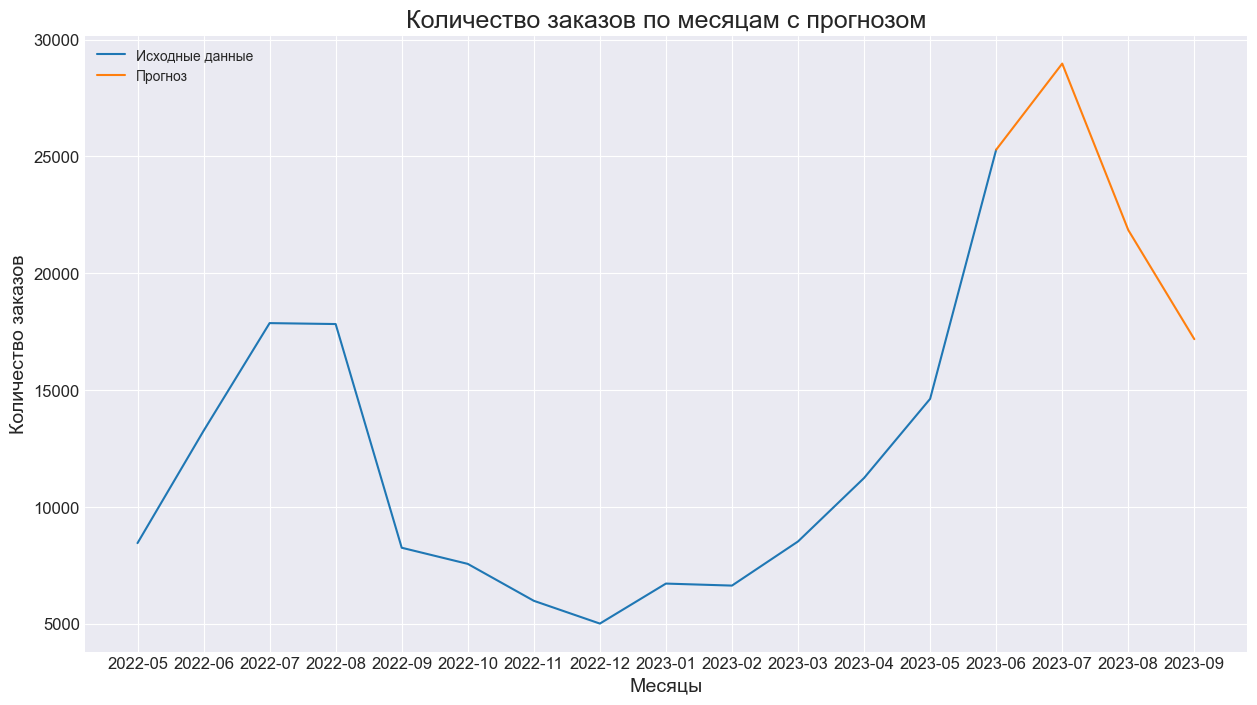

In [59]:
plt.figure(figsize=(15, 8))
plt.plot(predict_df.created_at, predict_df.id, label='Исходные данные')
plt.plot(['2023-06', '2023-07', '2023-08', '2023-09'], [predict_df.id[13], predict_07, predict_08, predict_09], label='Прогноз')
plt.title('Количество заказов по месяцам c прогнозом', fontsize=18)
plt.tick_params(labelsize=12)
plt.xlabel('Месяцы', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.legend(loc='upper left')
plt.show()

Если бы выбранные в пункте b пратнеры, начали работать эффективнее, прогнозируемое количество заказов бы увеличилось. Рассмотрим на примере.
Допустим, выбранные партнеры начали бы работать на 20% эффективнее.

Начать работать эффективнее на 20% - значит увеличить трафик на 20%. При увеличении трафика на 20%, количество заказов тоже увеличится на 20% (при сохранении прежнего уровня конверсии)

Здесь можно рассчитать прогнозную характеристику для каждой из компаний, а затем искусственно прибавить к каждой характеристике 20% заказов, но для выполнения данной задачи немного упростим работу и посчитаем прогнозную характеристику для всех этих 15 компаний одновременно.

In [60]:
top15 = df2[(df2.affiliate_id.isin(friendship_improve_list)) & (df2.state != 'canceled')]
tr = [i.strftime("%Y-%m") for i in top15.created_at]
top15.created_at = tr

In [61]:
top15 = top15.groupby(top15.created_at, as_index=False).count()[['created_at', 'id']]
top15["trend"] = predict_df["id"].rolling(window=12).mean()

In [62]:
t15_1 = np.polyfit([11, 12, 13], top15["trend"][11:], 1)
f15_1 = np.poly1d(t15_1)
print(f15_1)

 
758.7 x + 1345


In [63]:
predict15_07 = 758.7 * 4 + 1345
predict15_08 = 758.7 * 5 + 1345
predict15_09 = 758.7 * 6 + 1345

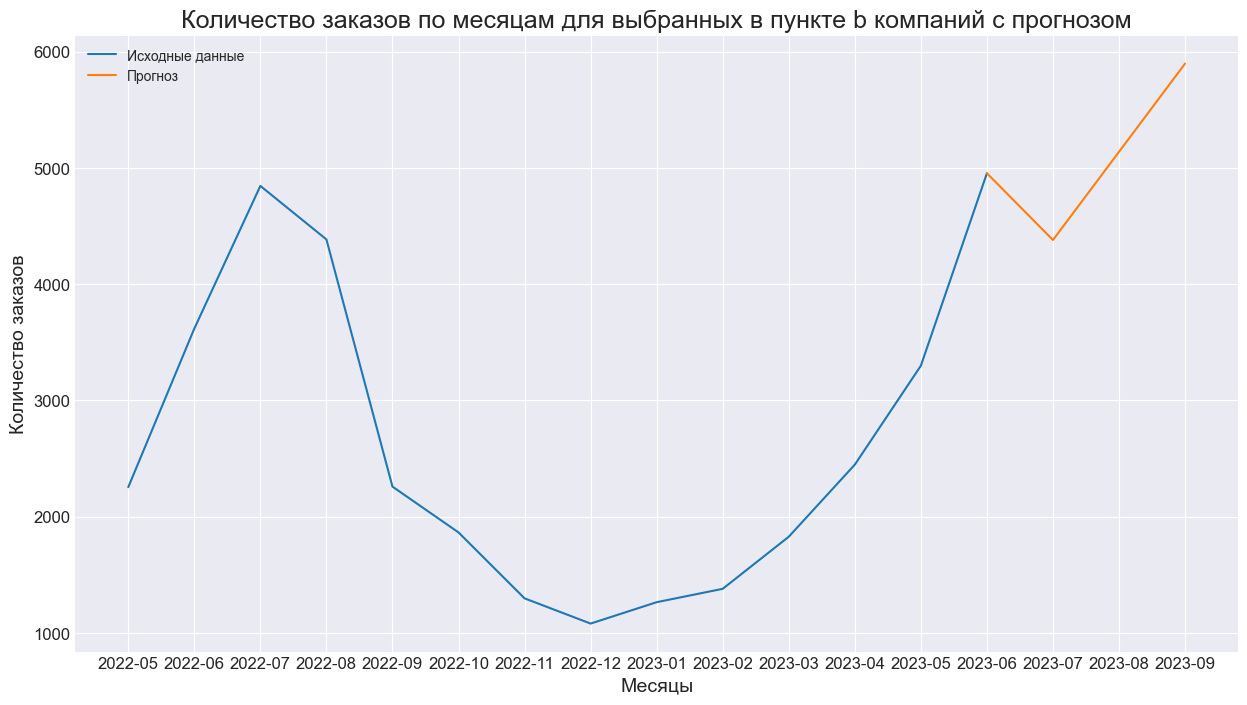

In [64]:
plt.figure(figsize=(15, 8))
plt.plot(top15.created_at, top15.id, label='Исходные данные')
plt.plot(['2023-06', '2023-07', '2023-08', '2023-09'], [top15.id[13], predict15_07, predict15_08, predict15_09], label='Прогноз')
plt.title('Количество заказов по месяцам для выбранных в пункте b компаний c прогнозом', fontsize=18)
plt.tick_params(labelsize=12)
plt.legend(loc='upper left')
plt.xlabel('Месяцы', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.show()

In [65]:
more_p_07 = predict15_07 * 0.2
more_p_08 = predict15_08 * 0.2
more_p_09 = predict15_09 * 0.2

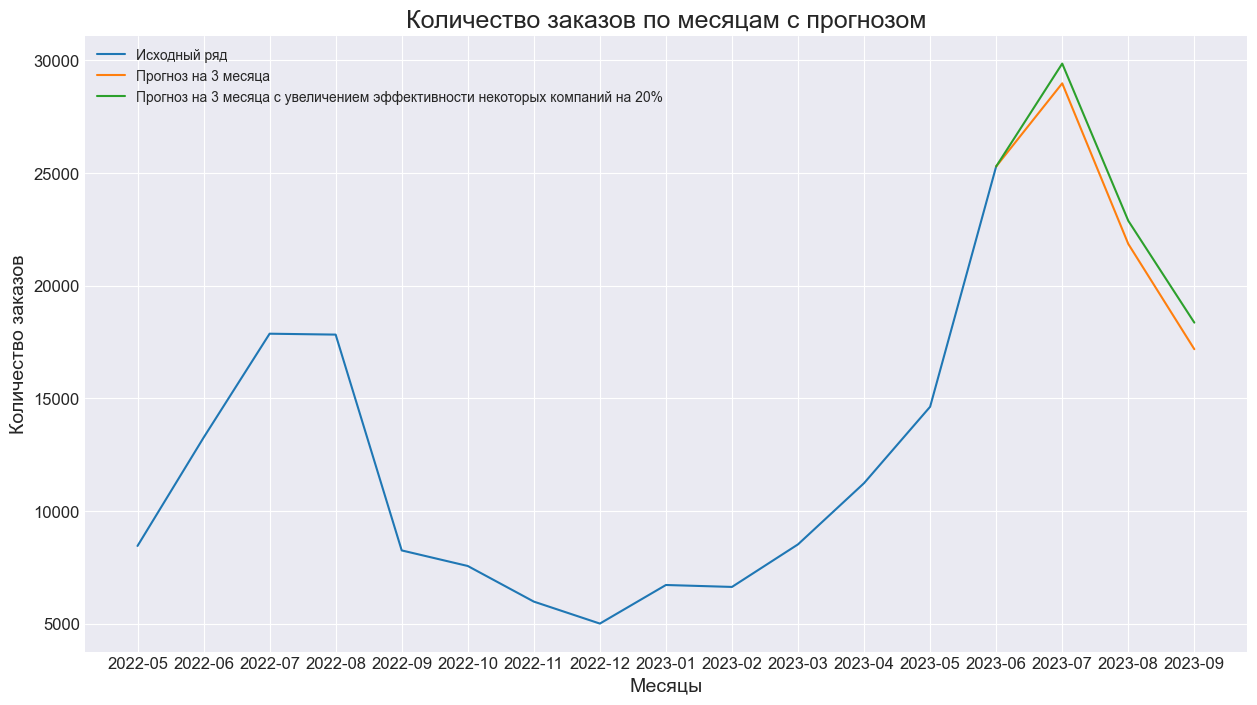

In [66]:
plt.figure(figsize=(15, 8))

plt.plot(predict_df.created_at, predict_df.id, label='Исходный ряд')

plt.plot(['2023-06', '2023-07', '2023-08', '2023-09'], 
         [predict_df.id[13], 
          predict_07, predict_08, predict_09], label='Прогноз на 3 месяца')

plt.plot(['2023-06', '2023-07', '2023-08', '2023-09'], 
         [predict_df.id[13], 
          predict_07 + more_p_07, predict_08 + more_p_08, predict_09 + more_p_09], 
          label='Прогноз на 3 месяца с увеличением эффективности некоторых компаний на 20%')

plt.legend(loc='upper left')
plt.title('Количество заказов по месяцам c прогнозом', fontsize=18)
plt.tick_params(labelsize=12)
plt.xlabel('Месяцы', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14)
plt.show()

<blockquote><h3>Выводы по пункту С</h3></blockquote>

Была построена прогнозная характеристика количества заказов на ближайшие 2 месяца. При увеличении эффективности на 20% компаний, выбранных в пункте b, в соответствии с прогнозом наблюдаются видимые изменения в лучшую сторону, что подтверждает, что с этими компаниями необходимо развивать сотрудничество.

<blockquote><h3>Необязательный пункт</h3></blockquote>

* Для полноценных выводов данных недостаточно, особенно для составления прогнозной характеристики. Скорее всего, в данных имеет место сезонность, но данных для подтверждения этого предположения недостаточно.
* Так же хотелось бы более тонко анализировать конверсию, чтобы делать более точные выводы по компаниям-партнерам. Если такая возможность имеется, просить компании-партнеры предоставлять данныt со своих сайтов о том, какая конверсию в клик по ссылке сайта sputnik

* Я бы проанализировал данные, связанные с ЦА партнеров и ЦА компании sputnik с целью разобраться в случаях, когда трафик относительно большой, а конверсия в покупку ничтожно мала, либо вообще равна нулю